# Replication: Nguyen *et al*, 2021

## Introduction

This notebook attempts to reproduce the following paper (which already uses the [PPMI](http://ppmi-info.org) dataset):

<div class="alert alert-block alert-success">
Nguyen KP, et al. <a href=https://doi:10.1016/j.parkreldis.2021.02.026>Predicting Parkinson's disease trajectory using clinical and neuroimaging baseline measures.</a> Parkinsonism Relat Disord. 2021;85:44-51. 
</div>

This study uses data from 82 PD subjects with rs-fMRI and MDS-UPDRS total score, encompassing both motor and non-motor symptomatology at the same visit. Of these 82 subjects, 53 subjects also had scores available at year 1 after imaging, 45 at year 2, and 33 at year 4. 

The fMRI data were acquired at resting-state on 3T scanners with the same acquisition parameters. Acquisition parameters are described below (table extracted from the original paper supplementary materials).

<img src="images/acquisition.png" width=800/>

The demographics parameters for the PD patients were as follows (table extracted from the paper):

<img src="images/demographics.png" width=800/>

The main goal of this paper is to use imaging features extracted from rs-fMRI data and demographic features to train machine learning models to predict MDS-UPDRS scores of PD patients.

Imaging features includes fractional Amplitude of Low Frequency Fluctuations (fALFF) and Regional Homogeneity (ReHo) averaged for different Regions of Interest (ROI) of the brain extracted from different atlases: [100-ROI Schaefer functional brain parcellation](https://doi.org/10.1093/cercor/bhx179), modified with an additional 35 striatal and cerebellar ROIs, 197-ROI and 444-ROI versions of the [Bootstrap Analysis of Stable Clusters (BASC197) atlas](https://doi.org/10.1016/j.neuroimage.2010.02.082).

Different machine learning models were compared: ElasticNet regression, Support Vector Machine (SVM) with a linear kernel, Random Forest with a decision tree kernel, and Gradient Boosting with a decision tree kernel. 

An unbiased random search was conducted to optimize the hyperparameters of each model, including regularization strength and learning rate. To determine the best-performing parcellation, hyperparameter, and model combination for each target, a rigorous nested cross-validation approach was applied, with leave-one-out cross-validation (LOOCV) as the outer loop and 10-fold cross-validation as the inner loop.

ReHo features explained 30.4%, 45.3%, 47.1%, and 25.5% of the variance in baseline, year 1, year 2, and year 4 MDS-UPDRS score, respectively. fALFF features explained 24.2%, 55.8%, 46.3%, and 15.2% of the variance in baseline, year 1, year 2, and year 4 MDS-UPDRS score, respectively. Results were significant at p = 0.001 (false discovery rate-corrected) at all timepoints except year 4, which was significant at p = 0.05.

Results are displayed below (table extracted from the original paper). 
<img src="images/results.png" width=800/>

## Initial setup

We first initialize the notebook cache and install dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=RuntimeWarning)

This notebook was run on 2023-09-18 20:49:27 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as closely as possible. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 

* Participant status (Parkinson's disease, healthy control, etc.)
* Demographics
* Age at visit
* Clinical/cognitive assessment results:
    * Montreal Cognitive Assessment (MoCA)
    * Unified Parkinson's Disease Rating Scale (UPDRS) Parts I, II and III
    * Geriatric Depression Scale (GDS)
    * Hoehn-Yahr stage

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, a PPMI username and password are required to obtain the files. New PPMI accounts can be requested [here](http://ppmi-info.org).

In [2]:
from nguyenetal.constants import (
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_PD_HISTORY,
    FILENAME_SOCIO,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_UPDRS3_CLEAN,
    FILENAME_UPDRS4,
    FILENAME_GDS,
    FILENAME_FMRI_INFO,
    FILENAME_FMRI_INFO_ZIP,
    FILENAME_FMRI_METADATA
)

from nguyenetal.constants import (
    COL_PAT_ID,
    COL_VISIT_TYPE,
    COL_STATUS,
    COL_PD_STATE,
    COL_AGE,
    COL_SEX,
    COL_EDUCATION,
    COL_UPDRS3,
    COL_UPDRS1A,
    COL_UPDRS1B,
    COL_UPDRS1,
    COL_UPDRS2,
    COL_UPDRS4,
    COL_MOCA,
)

from nguyenetal.constants import (
    COL_DATE_INFO,
    COL_DATE_BIRTH,
    COL_DATE_PD,
    FIELD_STRENGTH,
    STATUS_PD
    
)

from nguyenetal.constants import (
    COL_IMAGING_PROTOCOL,
    COLS_DATE, 
    IDA_STATUS_MAP,
    IDA_COLNAME_MAP,
    IDA_VISIT_MAP,
    STATUS_MED,
)

from nguyenetal.utils.cohort_utils import (
    load_ppmi_csv,
    get_fMRI_cohort,
    mean_impute,
    compute_summary_features,
    get_features,
    get_threshold, 
    get_outcome_measures
)

from livingpark_utils.scripts import pd_status
from livingpark_utils.dataset.ppmi import disease_duration

from functools import reduce
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 500)
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
#sns.set_palette("rocket")

This notebook was run on 2023-09-18 20:49:27 UTC +0000
This notebook was run on 2023-09-18 20:49:28 UTC +0000
Download skipped: No missing files!
File downloaded
Removed 76 records where PDSTATE=ON and EXAMTM<PDMEDTM
Number of removed records: 1
Number of removed records: 60
Number of removed records: 10
Cleaned file saved in MDS_UPDRS_Part_III_clean.csv
True


In [3]:
from livingpark_utils.download.ppmi import Downloader

required_files = [
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_PD_HISTORY,
    FILENAME_DEMOGRAPHICS,
    FILENAME_SOCIO,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_UPDRS4,
    FILENAME_GDS
]

downloader = Downloader(utils.study_files_dir)
utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


In [4]:
import ppmi_downloader
import os
mri_file_name = "fMRI_info.csv"
if not os.path.exists(os.path.join(utils.study_files_dir, mri_file_name)):
    ppmi = ppmi_downloader.PPMIDownloader()
    file_name = ppmi.download_fmri_info(destination_dir=utils.study_files_dir)
    os.rename(
        os.path.join(utils.study_files_dir, file_name),
        os.path.join(utils.study_files_dir, mri_file_name),
    )

The main cohort contains 82 participants from either the `Parkinson's Disease` or the `GenCohort PD` cohort of PPMI. These 82 participants have rs-fMRI and outcome scores at the same visit available. MDS-UPDRS scores included the Part III Motor Examination conducted on-medication. Off-medication scores were not used due to unavailability for over half of the subjects and because examinations are more practically conducted on-medication in the clinic. 

We selected participants that:
* belonged to the selected cohort
* had fMRI scans with same acquisition parameters as those used in the paper.

### Participants with fMRI data available

In [5]:
print(f"=============== fMRI cohort ===============")
df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)
df_fMRI_subset = get_fMRI_cohort(utils)

# cohort composition: number of PD patients/healthy controls
print(
    df_status.loc[
        df_status[COL_PAT_ID].isin(df_fMRI_subset[COL_PAT_ID]), COL_STATUS
    ].value_counts()
)

=============== fMRI cohort ===============
Using fMRI info file: /Users/egermani/Documents/nguyen-etal-2021/inputs/study_files/fMRI_info.csv
Dropping 258 subjects with non-integer IDs
COHORT_DEFINITION
Parkinson's Disease    118
Name: count, dtype: int64


Then, we load/compute and merge all the required clinical/cognitive measures:
* UPDRS Part I
* UPDRS Part II
* UPDRS Part III
* UPDRS Part IV
* MoCA
* GDS Score

Missing values are imputed with the mean across the entire dataset, except for the UPDRS Part III score (handled below).

There are two files associated with UPDRS Part I (IA: Complex behaviors; IB: Partipant questionnaire). We use the sum of the total score in each file.

In [6]:
cols_for_merge = [COL_PAT_ID, COL_DATE_INFO, COL_VISIT_TYPE]

# Load necessary files
df_updrs1a = load_ppmi_csv(utils, FILENAME_UPDRS1A, convert_int = [COL_UPDRS1A])
df_updrs1b = load_ppmi_csv(utils, FILENAME_UPDRS1B, convert_int = [COL_UPDRS1B])
df_updrs2 = load_ppmi_csv(utils, FILENAME_UPDRS2, convert_int = [COL_UPDRS2])
df_updrs3 = load_ppmi_csv(utils, FILENAME_UPDRS3_CLEAN, convert_int = [COL_UPDRS3])
df_updrs4 = load_ppmi_csv(utils, FILENAME_UPDRS4, convert_int = [COL_UPDRS4], cols_to_impute=COL_UPDRS4)

df_moca = load_ppmi_csv(utils, FILENAME_MOCA, convert_int = [COL_MOCA])
df_gds = load_ppmi_csv(utils, FILENAME_GDS)

# Sum UPDRS IA and IB scores
df_updrs1 = df_updrs1a.merge(df_updrs1b, on=cols_for_merge)
df_updrs1[COL_UPDRS1] = df_updrs1.loc[:, [COL_UPDRS1A, COL_UPDRS1B]].sum(axis="columns")

# Drop unused UPDRSIII scores (only ON medication)
df_updrs3 = df_updrs3.drop(df_updrs3.index[(df_updrs3['PAG_NAME'] == 'NUPDRS3') & \
                         (df_updrs3['EVENT_ID'].isin(['V04', 'V06', 'V08', 'V10', 'V12', 'V13', 'V15']))])
#df_updrs3 = df_updrs3.drop(df_updrs3.index[(df_updrs3['PAG_NAME'] == 'NUPDR3OF')])
#df_updrs3 = df_updrs3.drop(df_updrs3.index[(df_updrs3['PAG_NAME'] == 'NUPDR3ON')])

# Select UPDRS columns to merge
df_updrs1 = df_updrs1.loc[:, cols_for_merge + [COL_UPDRS1]]
df_updrs2 = df_updrs2.loc[:, cols_for_merge + [COL_UPDRS2]]
df_updrs3 = df_updrs3.loc[:, cols_for_merge + [COL_UPDRS3, 'NHY', 'PAG_NAME', 'PDSTATE']]
df_updrs4 = df_updrs4.loc[:, cols_for_merge + [COL_UPDRS4]]

# Compute GDS total score 
gds_cols = df_gds.columns[['GDS' in strcol for strcol in df_gds.columns]].tolist()
df_gds['GDS_TOTAL'] = df_gds[gds_cols].sum(axis=1)
df_gds = df_gds.loc[:, cols_for_merge + ['GDS_TOTAL']]

# Select MOCA columns to merge
df_moca = df_moca.loc[:, cols_for_merge + [COL_MOCA]]

# Merge 
df_assessments_all = reduce(
    lambda df1, df2: df1.merge(df2, on=cols_for_merge, how="outer"),
    [df_updrs2, df_updrs3, df_updrs1, df_updrs4, df_moca, df_gds],
).drop_duplicates()

# Compute TOTAL UPDRS SCORE 
updrs_cols = [COL_UPDRS1, COL_UPDRS2, COL_UPDRS3, COL_UPDRS4]
df_assessments_all['UPDRS_TOT'] = df_assessments_all[updrs_cols].sum(axis=1)
   
# Only keep cohort participants
df_cohort_assessments = df_assessments_all.loc[
    df_assessments_all[COL_PAT_ID].isin(df_fMRI_subset[COL_PAT_ID])]

# Drop participants that don't have UPDRS III Score
df_cohort_assessments = df_cohort_assessments.dropna(subset=['NP3TOT'])

Only participants with outcome score (UPDRS) and rs-fMRI data at the same visit were used, so we filter both datasets to keep only participants sessions that have both. 

In [7]:
df_fMRI_cohort = pd.DataFrame()
for i in range(len(df_cohort_assessments)):
    df_fMRI_cohort = pd.concat([df_fMRI_cohort, 
                        df_fMRI_subset[df_fMRI_subset[COL_PAT_ID] == df_cohort_assessments.iloc[i][COL_PAT_ID]]\
                        [df_fMRI_subset[COL_VISIT_TYPE] == df_cohort_assessments.iloc[i][COL_VISIT_TYPE]]]
                        )
    
df_scores_cohort = pd.DataFrame()
for i in range(len(df_fMRI_subset)):
    df_scores_cohort = pd.concat([df_scores_cohort, 
                    df_cohort_assessments[df_cohort_assessments[COL_PAT_ID] == df_fMRI_subset.iloc[i][COL_PAT_ID]]\
                    [df_cohort_assessments[COL_VISIT_TYPE] == df_fMRI_subset.iloc[i][COL_VISIT_TYPE]]]
                    )

In [8]:
fMRI_cols_to_include = ['PATNO', 'Sex','COHORT_DEFINITION','EVENT_ID', 'INFODT', 'Age', 
                        'Description', 'Imaging Protocol', 'Image ID']
scores_cols_to_include = ['PATNO', 'EVENT_ID','PAG_NAME' ,'NP2PTOT', 'NP3TOT', 'NP1RTOT+NP1PTOT',
       'NP4TOT', 'NHY','MCATOT', 'GDS_TOTAL', 'UPDRS_TOT']

df_fMRI_cohort = df_fMRI_cohort.loc[:, fMRI_cols_to_include]
df_scores_cohort = df_scores_cohort.loc[:, scores_cols_to_include]

# Merge important columns from both datasets
df_global_cohort = df_fMRI_cohort.merge(df_scores_cohort, on=[COL_PAT_ID, COL_VISIT_TYPE])
df_global_cohort = df_global_cohort.sort_values(by=['PATNO','INFODT'])

### Baseline cohort

For the training, authors used the first scan & outcome score available for each participant. 

In [9]:
df_global_cohort_baseline = df_global_cohort.drop_duplicates(subset=COL_PAT_ID)
df_global_cohort_baseline = df_global_cohort_baseline[
    df_global_cohort_baseline[COL_DATE_INFO] < pd.Timestamp(2020, 1, 1, 12)
    ] # Removed due to the date of the study

In [10]:
print('Number of participants selected using papers informations:', len(df_global_cohort_baseline))

Number of participants selected using papers informations: 102


### Prediction cohort 

In the paper, authors are trying to predict UPDRS scores at baseline (same session as fMRI data), 1 year after, 2 years after and 4 years after. 

In [11]:
# DF with outcome scores for every participants
df_global_cohort_pred = df_cohort_assessments[df_cohort_assessments\
                                              [COL_PAT_ID].isin(df_global_cohort_baseline[COL_PAT_ID].tolist())]

# Filter by date due to the date of publication of the paper. 
df_global_cohort_pred = df_global_cohort_pred[df_global_cohort_pred[COL_DATE_INFO] < pd.Timestamp(2020, 1, 1, 12)]

# Event taken as Baseline
df_global_cohort_pred['BASELINE_EV'] = [df_global_cohort_baseline[COL_VISIT_TYPE]\
                [df_global_cohort_baseline[COL_PAT_ID] == df_global_cohort_pred[COL_PAT_ID].iloc[i]].iloc[0] \
                             for i in range(len(df_global_cohort_pred))]


In [12]:
eq_1year = {
    'BL':'V04',
    'ST':'V04',
    'V04':'V06',
    'V06':'V08',
    'V08':'V10',
    'V10':'V12'
}

eq_2year = {
    'BL':'V06',
    'ST':'V06',
    'V04':'V08',
    'V06':'V10',
    'V08':'V12',
    'V10':'V13'
}

eq_4year = {
    'BL':'V10',
    'ST':'V10',
    'V04':'V12',
    'V06':'V13',
    'V08':'V14',
    'V10':'V15'
}

In [13]:
df_global_cohort_pred['1Y_EVENT'] = [eq_1year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]
df_global_cohort_pred['2Y_EVENT'] = [eq_2year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]
df_global_cohort_pred['4Y_EVENT'] = [eq_4year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]

In [14]:
df_global_1y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['1Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_1y = df_global_1y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

df_global_2y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['2Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_2y = df_global_2y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

df_global_4y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['4Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_4y = df_global_4y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

In [15]:
print('Number of participants for 1y cohort: ', len(df_global_1y))
print('Number of participants for 2y cohort: ', len(df_global_2y))
print('Number of participants for 4y cohort: ', len(df_global_4y))

Number of participants for 1y cohort:  63
Number of participants for 2y cohort:  68
Number of participants for 4y cohort:  47


### Global cohort

Using the information that we had in the paper, we were able to select 105 participants against 82 mentioned in the paper. We create a demographics table similar to the one in the original paper to verify our cohort. 

In [16]:
df_allyears_summary = pd.DataFrame(columns = [('Baseline', 'Original'), ('Baseline', 'Replication'),
                                              ('Year 1', 'Original'), ('Year 1', 'Replication'), 
                                              ('Year 2', 'Original'), ('Year 2', 'Replication'), 
                                              ('Year 4', 'Original'), ('Year 4', 'Replication')])

df_allyears_summary[('Baseline', 'Original')]=['95.1','2.4','3.7','1.2','67.0','89.0','62.1 ± 9.8',
 '15.6 ± 3.0','770 ± 565','33.9 ± 15.8','-','26.7 ± 2.8','5.4 ± 1.4','1.8 ± 0.5']

df_allyears_summary[('Year 1', 'Original')] = ['94.4','1.9','5.6','0','68.5','85.2','61.9 ± 10.3',
 '15.1 ± 3.2','808 ± 576','38.0 ± 20.9','39.2 ± 21.6','26.9 ± 3.2','5.4 ± 1.6','1.8 ± 0.5']

df_allyears_summary[('Year 2', 'Original')] = ['97.8','0','4.4','0','82.2','88.9','63.6 ± 9.2',
 '15.1 ± 3.3','771 ± 506','40.2 ± 18.2','40.9 ± 18.5','26.7 ± 3.5','5.4 ± 1.2','1.8 ± 0.5']

df_allyears_summary[('Year 4', 'Original')] = ['97.0','0','3.0','0','75.8','87.9','59.5 ± 11.0',
    '15.0 ± 3.4','532 ± 346','34.9 ± 15.7','35.9 ± 16.5','27.5 ± 2.3','5.4 ± 1.7','1.7 ± 0.5']

df_allyears_summary[('Baseline', 'Replication')] = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').tolist()
df_allyears_summary[('Year 1', 'Replication')] = compute_summary_features(df_global_1y, utils,
                                                                '1Y', df_global_cohort_baseline).tolist()
df_allyears_summary[('Year 2', 'Replication')] = compute_summary_features(df_global_2y, utils,
                                                                '2Y', df_global_cohort_baseline).tolist()
df_allyears_summary[('Year 4', 'Replication')] = compute_summary_features(df_global_4y, utils,
                                                                '4Y', df_global_cohort_baseline).tolist()

df_allyears_summary.index = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').index

df_allyears_summary.loc['Number of subject'] = [82, len(df_global_cohort_baseline), 53, len(df_global_1y), 
                                      45, len(df_global_2y), 33, len(df_global_4y)]

df_allyears_summary.columns = pd.MultiIndex.from_tuples(df_allyears_summary.columns)
df_allyears_summary

Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!


Baseline                 \
                                            Original    Replication   
% Caucasian                                     95.1           95.1   
% African-American                               2.4            2.0   
% Asian                                          3.7            2.9   
% Hispanic                                       1.2            1.0   
% Male                                          67.0           66.7   
% right-handed                                  89.0           89.2   
Mean age, years                           62.1 ± 9.8     62.1 ± 9.5   
Mean years of education                   15.6 ± 3.0     15.6 ± 2.8   
Mean disease duration at baseline, days    770 ± 565  870.4 ± 597.1   
Mean MDS-UPDRS at baseline               33.9 ± 15.8    34.5 ± 15.6   
Mean MDS-UPDRS at timepoint                        -              -   
Mean MoCA at baseline                     26.7 ± 2.8     26.5 ± 3.0   
Mean GDS at Baseline                       5.4 ± 1.4      5.4 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 82            102   

                                              Year 1                 \
                                            Original    Replication   
% Caucasian                                     94.4           95.2   
% African-American                               1.9            1.6   
% Asian                                          5.6            3.2   
% Hispanic                                         0            1.6   
% Male                                          68.5           65.1   
% right-handed                                  85.2           87.3   
Mean age, years                          61.9 ± 10.3     62.5 ± 9.7   
Mean years of education                   15.1 ± 3.2     15.1 ± 2.6   
Mean disease duration at baseline, days    808 ± 576  998.3 ± 593.1   
Mean MDS-UPDRS at baseline               38.0 ± 20.9    33.7 ± 15.3   
Mean MDS-UPDRS at timepoint              39.2 ± 21.6    39.5 ± 22.2   
Mean MoCA at baseline                     26.9 ± 3.2     27.0 ± 2.9   
Mean GDS at Baseline                       5.4 ± 1.6      5.5 ± 1.7   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 53             63   

                                              Year 2                 \
                                            Original    Replication   
% Caucasian                                     97.8           97.1   
% African-American                                 0            0.0   
% Asian                                          4.4            2.9   
% Hispanic                                         0            1.5   
% Male                                          82.2           76.5   
% right-handed                                  88.9           91.2   
Mean age, years                           63.6 ± 9.2     63.5 ± 9.8   
Mean years of education                   15.1 ± 3.3     15.3 ± 2.7   
Mean disease duration at baseline, days    771 ± 506  902.9 ± 566.4   
Mean MDS-UPDRS at baseline               40.2 ± 18.2    34.0 ± 15.2   
Mean MDS-UPDRS at timepoint              40.9 ± 18.5    40.7 ± 19.7   
Mean MoCA at baseline                     26.7 ± 3.5     26.9 ± 2.4   
Mean GDS at Baseline                       5.4 ± 1.2      5.5 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.8 ± 0.5   
Number of subject                                 45             68   

                                              Year 4                 
                                            Original    Replication  
% Caucasian                                     97.0           97.9  
% African-American                                 0            0.0  
% Asian                                          3.0            2.1  
% Hispanic                                         0            0.0  


The values obtained in this table are basically similar to those in the paper, except in terms of number of participants. The original baseline cohort was composed of 82 participants compared to 102 in our case. Year 1, 2 and 4 cohorts also exhibit a larger number of participants than in the original paper. 

Mean values of demographics and clinical features are similar to those of the original paper. 

To obtain the same number of participants in each cohort, we will randomly sample the same number of participants as those used in the paper and perform the replication on these participants.

In [17]:
df_cohort_baseline = df_global_cohort_baseline
df_cohort_1y = df_global_1y
df_cohort_2y = df_global_2y
df_cohort_4y = df_global_4y

### Extracting image informations for each cohort

We create a dataframe with only informations regarding the images of participants for each cohort. 

In [18]:
df_fmri_cohort_baseline = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']]

df_fmri_cohort_1y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_1y[COL_PAT_ID].tolist())]

df_fmri_cohort_2y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_2y[COL_PAT_ID].tolist())]

df_fmri_cohort_4y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_4y[COL_PAT_ID].tolist())]

fMRI data are associated with anatomical T1 data, often necessary for preprocessing. 

We searched for the T1 data acquired during the same session as the fMRI ones for the baseline cohort. We chose the first one each time.

In [19]:
from livingpark_utils.scripts import run
from livingpark_utils.scripts import mri_metadata

run.mri_metadata()

This notebook was run on 2023-09-18 20:49:40 UTC +0000
['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'Ax', 'axial', 'Phantom', 'T2']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 6': 'V02', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv


In [20]:
df_mri = load_ppmi_csv(utils, '3D_mri_info.csv', from_ida_search=True)

df_mri_cohort_baseline = df_mri.merge(df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE]], 
                      on = [COL_PAT_ID, COL_VISIT_TYPE])
df_mri_cohort_baseline = df_mri_cohort_baseline.sort_values(by=[COL_PAT_ID,'Description'])
df_mri_cohort_baseline = df_mri_cohort_baseline.drop_duplicates(subset=[COL_PAT_ID])

df_mri_cohort_1y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_1y[COL_PAT_ID].tolist())]

df_mri_cohort_2y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_2y[COL_PAT_ID].tolist())]

df_mri_cohort_4y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_4y[COL_PAT_ID].tolist())]

Dropping 3 subjects with non-integer IDs


## Extracting features for machine learning models

### Clinical and demographics

In the paper, authors reported having used different clinical and demographic features along with the radiomic data to train the models. 
These included:
* **Clinical features**: disease duration, symptom duration, dominant symptom side, Geriatric Depression Scale (GDS), Montreal Cognitive Assessment (MoCA), and presence of tremor, rigidity, or postural instability at baseline. Baseline MDS-UPDRS score was also included as a confounding variable when training models to predict future outcomes. 
* **Demographic features**: age, sex, ethnicity, race, handedness, and years of education.

<div class="alert alert-block alert-danger">
    Dominant side is not included on PD features in the PPMI database, so we removed it from the used features.
</div>

In [21]:
df_features_cohort_baseline = get_features(df_cohort_baseline, utils,
                                  df_cohort_baseline[COL_PAT_ID].tolist(), 
                                 timepoint='baseline')

df_features_cohort_1y = get_features(df_cohort_baseline, utils,
                                  df_cohort_1y[COL_PAT_ID].tolist(), 
                                 timepoint='1y')

df_features_cohort_2y = get_features(df_cohort_baseline, utils,
                                  df_cohort_2y[COL_PAT_ID].tolist(), 
                                 timepoint='2y')

df_features_cohort_4y = get_features(df_cohort_baseline, utils,
                                  df_cohort_4y[COL_PAT_ID].tolist(), 
                                 timepoint='4y')

### Outcome measures 

* The outcome of interest is the MDS-UPDRS total score, encompassing both motor and non-motor symptomatology. 
* As a secondary outcome measure, an MDS-UPDRS score threshold was used to dichotomize subjects into high- and low-severity groups. A threshold of 35 was selected, which was the average of the median MDS-UPDRS score at each of the four timepoints.
  
It is mentioned in the paper that there were no differences between the high- and low-severity groups in motor predominance (Part III score as a percentage of total score) at p = 0.05.


In [22]:
threshold = get_threshold(df_cohort_baseline, df_cohort_1y, df_cohort_2y, df_cohort_4y)

In [23]:
df_outcome_baseline = get_outcome_measures(df_cohort_baseline, threshold)
df_outcome_1y = get_outcome_measures(df_cohort_1y, threshold)
df_outcome_2y = get_outcome_measures(df_cohort_2y, threshold)
df_outcome_4y = get_outcome_measures(df_cohort_4y, threshold)

In [24]:
# Verify that there were no differences between the high- and low-severity groups in motor predominance 
# (Part III score as a percentage of total score) at p = 0.05.
from scipy.stats import ttest_ind

for i, df in enumerate([df_outcome_baseline, df_outcome_1y, df_outcome_2y, df_outcome_4y]):
    df['PERC_UPDRS3'] = df['NP3TOT']/df['UPDRS_TOT']

    perc_updrs3_highsev = df['PERC_UPDRS3'][df[f'SEVERITY']==1].tolist()
    perc_updrs3_lowsev = df['PERC_UPDRS3'][df[f'SEVERITY']==0].tolist()

    if i == 0:
        time = 'Baseline'
    elif i < 3:
        time = f'{i+1} years'
    else:
        time = '4 years'
        
    print(time, ':', round(ttest_ind(perc_updrs3_highsev, perc_updrs3_lowsev)[1], 3))

Baseline : 0.128
2 years : 0.072
3 years : 0.643
4 years : 0.534


The distribution of the UPDRS-Score at Baseline and 1 year are also given in the supplementary materials. We tried to reproduce these figures. 

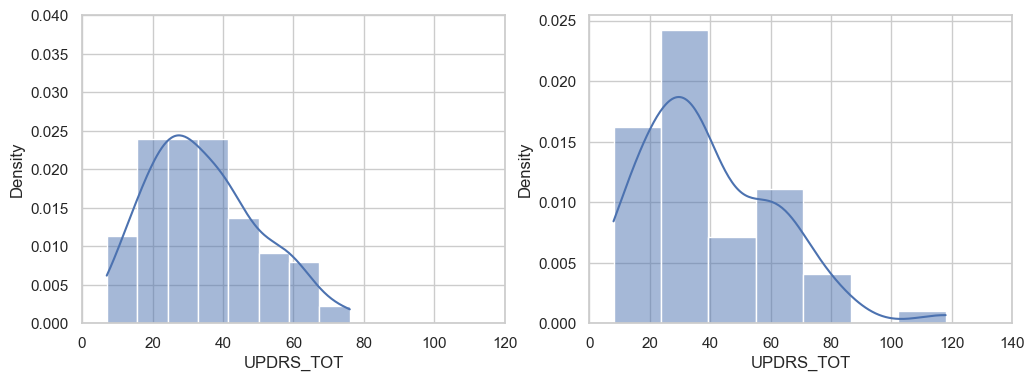

In [25]:
f = plt.figure(figsize = (12, 4))
gs = f.add_gridspec(1, 2)

ax1 = f.add_subplot(gs[0, 0])
ax1.set_xlim(0,120)
ax1.set_ylim(0, 0.04)

sns.histplot(df_outcome_baseline, x = 'UPDRS_TOT', axes=ax1, kde=True, stat='density')
ax2 = f.add_subplot(gs[0, 1])
ax2.set_xlim(0,140)
sns.histplot(df_outcome_1y,
             x = 'UPDRS_TOT', axes=ax2, kde=True, stat='density')
            
plt.show()

Reported plot in the original paper are shown below. 

<img src="images/outcome_distribution.png" width=1000/>

## Imaging features

### Functional pre-processing

In the paper, preprocessing of functional images is mentioned as below: 
- fMRI images were first realigned to the mean volume with affine transformations to correct for inter-volume head motion, using the MCFLIRT tool in FSL.
- Brain masking was performed using AFNI 3dAutomask.
- The images were next nonlinearly coregistered directly to a common EPI template in MNI space, because direct EPI spatial normalization corrects for more nonlinear magnetic susceptibility artifacts than T1-based normalization. This nonlinear normalization step was performed using the Symmetric Normalization algorithm in ANTS.

We reproduced these steps in the `Functional_Preprocessing` workflow. 

In [26]:
# from nguyenetal.workflows import func_preprocessing_wf
# from glob import glob

# base_dir = '/Users/egermani/Documents/nguyen-etal-2021'
# subject_list = [f.split('/')[-1].split('-')[-1] for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')]
# data_dir = f'{base_dir}/inputs/data/Nifti'
# output_dir = f'{base_dir}/inputs/data/Nifti/derivatives'

# preprocessing_wf = func_preprocessing_wf.Functional_Preprocessing(data_dir, 
#                                                                 output_dir, 
#                                                                 subject_list)

# preprocessing_wf.pipeline.run()

### Denoising

After spatial preprocessing, authors mentioned the use of confounds regressors to remove the effect of movements or other signals. 
*"Because individuals with PD may exhibit substantial head motion during imaging, it is crucial to correct for head motion artifacts in fMRI data. Left uncorrected, these artifacts may introduce spurious and confounding signals into subsequent analysis. Recent work suggests that all fMRI nuisance regression should be performed simultaneously to avoid reintroduction of noise. Accordingly, motion-related regressors computed using ICA-AROMA were concatenated with the nuisance regressors from affine head motion parameters and white matter and cerebrospinal fluid, and these nuisance signals were regressed out of the fMRI data in one step"*

Affine head motion parameters are already computed during spatial preprocessing using `MCFLIRT`, but we still need to compute:
- ICA-AROMA motion-related regressors
- White matter and CSF signals 

#### ICA-AROMA

In [27]:
### WRITE STEPS FOR ICA-AROMA

#### Global signals

The computation of the global signals is not described in the paper. Thus, we implemented two different strategies to compute these signals: 
- using `AFNI` software package
- using `FSL` software package.

In [28]:
# from os.path import join
# from nguyenetal.workflows import anat_preprocessing_wf
# from glob import glob 
# base_dir = '/srv/tempdd/egermani'
# subject_list = [f.split('/')[-1].split('-')[-1] for f in glob(f'{base_dir}/inputs/data/Nifti/sub-*')]
# data_dir = '/srv/tempdd/egermani/ppmi-dataset' 

# anat_file_template = join('bids', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')

# func_file_template = join('derivatives', 'fmriprep', 
#                           'sub-{subject_id}', 'func', 
#                           'sub-{subject_id}_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')

# output_dir='/srv/tempdd/egermani/nguyen-etal-2021/outputs'
# software='afni'

# wf = anat_preprocessing_wf.Anatomical_Preprocessing(subject_list, data_dir, 
#                                                     anat_file_template, func_file_template, output_dir, 
#                                                     software)

#### Confounds regression

Noise regression pipeline is implemented using FSL. 3 parameters files are required: 
- **Affine head motion parameters**
    - no header or index column
    - e.g. those used for input to ICA-AROMA
- **White-matter and csf signals**
    - no index column
    - header which contains `white_matter` and `csf` column ids corresponding to the signal of interest
    - e.g. those output from fmriprep or computed using `Anatomical_Preprocessing` workflow.
- **ICA-AROMA motion related regressors**
    - the computation of this file is included in the workflow, you only need to have run ICA-AROMA before (see above) and give the directory where ALL subjects ICA-AROMA outputs are stored.
    - e.g. `/outputs/ica-aroma` which contains `sub-*` directories.

In [29]:
# from glob import glob
# from nguyenetal.workflows import confound_reg_wf
# from os.path import join

# pipeline='reproduction_pipeline'
# data_dir=f'/srv/tempdd/egermani/nguyen-etal-2021/outputs/{pipeline}'
# output_dir=f'/srv/tempdd/egermani/nguyen-etal-2021/outputs/{pipeline}'

# subject_list = sorted([f.split('/')[-1].split('-')[-1] \
#                        for f in glob(f'{data_dir}/sub-*')])

# wm_csf_template= join('anat_preproc_fsl', 'sub-{subject_id}', 
#                                   'sub-{subject_id}_task-rest_desc-confounds_timeseries.tsv'
#                                  )

# motion_regressors_template = join('func_preproc','_subject_id_{subject_id}', 
#                                   'sub-{subject_id}_task-rest_bold_mcf.nii.gz.par'
#                                  )

# func_file_template = join('func_preproc', '_subject_id_{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans.nii.gz'
#                          )

# include_ICA=True
# ica_directory = f'/srv/tempdd/egermani/nguyen-etal-2021/outputs/{pipeline}/ica-aroma'

# wf = confound_reg_wf.NoiseRegression_Pipeline(subject_list, data_dir, output_dir, 
#         wm_csf_template, motion_regressors_template, func_file_template,
#         include_ICA, ica_directory)

# wf.pipeline.run()

## Compute imaging features

In the paper, authors used demographic features among with imaging features to predict UPDRS-III scores. These demographic features include Regional homogeneity and fractional amplitude of low frequency fluctuations. The details of the computation are described below:

*"Regional homogeneity (ReHo) and fractional amplitude of low frequency fluctuations (fALFF) were computed from the cleaned fMRI using C-PAC. ReHo was computed using Kendall’s coefficient of concordance between each voxel and its 27-voxel neighborhood. Low frequency power was measured by applying linear detrending and bandpass filtering at 0.01–0.1 Hz to each voxel’s signal, then computing the standard deviation of the signal. This frequency band was chosen based on standard fALFF methodology and previous PD studies successfully employing similar bands. The low frequency power was divided by the standard deviation of the unfiltered signal to obtain the normalized measure, fALFF. To normalize the values, the Z-scores for ReHo and fALFF were calculated per subject."*

Here, we reproduced the pipeline used by the authors (published on [GitHub](https://github.com/DeepLearningForPrecisionHealthLab/Parkinson-Severity-rsfMRI/blob/master/ppmiutils/rsfmri.py)) to compute these two metrics at a whole-brain level. 

They used mean regional values as input to the machine learning models. These values were computed by applying an atlas parcellation on the brain images and computing the mean values per region of interest (ROI).

*"To extract regional features from the ReHo and fALFF maps, three different brain parcellations of increasing granularity were applied. These included the 100-ROI Schaefer functional brain parcellation, modified with an additional 35 striatal and cerebellar ROIs  and the 197-ROI and 444-ROI versions of the Bootstrap Analysis of Stable Clusters (BASC197) atlas. These parcellations were used to compute the mean regional ReHo or fALFF values for each subject, and the parcellation with the highest predictive value was automatically identified during subsequent hyperparameter optimization.*

For the modified Schaefer atlas, the 35 striatal and cerebellar ROIs were obtained from FSL atlases: 
- `Cerebellum-MNIfnirt-maxprob-thr25-2mm.nii.gz` for the cerebellar
- `striatum-con-label-thr25-7sub-2mm.nii.gz` for the striatum. 

In [30]:
# from nguyenetal.workflows import static_measures_wf
# from glob import glob
# from os.path import join

# subject_list = sorted([f.split('/')[-1].split('-')[-1] \
#                        for f in glob(f'/srv/tempdd/egermani/nguyen-etal-2021/inputs/data/Nifti/sub-*')])

# data_dir = f'/srv/tempdd/egermani'
# output_dir = f'/srv/tempdd/egermani/nguyen-etal-2021/outputs/reproduction_pipeline'

# func_file_template = join('nguyen-etal-2021','outputs', 'reproduction_pipeline', 'denoising' ,'sub-{subject_id}',
#                           'sub-{subject_id}_task-rest_bold_mcf_masked_trans_regfilt.nii.gz')
# mask_file_template = '/opt/fsl-6.0.6.1/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'

# cereb_atlas = f'/srv/tempdd/egermani/nguyen-etal-2021/inputs/atlases/Cerebellum-MNIfnirt-maxprob-thr25-2mm.nii.gz'
# striatum_atlas = f'/srv/tempdd/egermani/nguyen-etal-2021/inputs/atlases/striatum-con-label-thr25-7sub-2mm.nii.gz'

# alff_reho_wf = static_measures_wf.StaticMeasures_Pipeline(subject_list, data_dir, output_dir, 
#                                                           mask_file_template, func_file_template,
#                                                           cereb_atlas, striatum_atlas,
#                                                           high_pass_filter=0.01, low_pass_filter=0.1, 
#                                                           cluster_size=27)

# alff_reho_wf.pipeline.run()

## Train machine learning models

In the paper, they mentioned that *four machine learning models of varying statistical complexity, implemented in the scikit-learn Python package, were tested for each target x feature combination: ElasticNet regression, Support Vector Machine (SVM) with a linear kernel, Random Forest with a decision tree kernel, and Gradient Boosting with a decision tree kernel. An unbiased random search was conducted to optimize the hyperparameters of each model, including regularization strength and learning rate. To determine the best-performing parcellation, hyperparameter, and model combination for each target, a rigorous nested cross-validation approach was applied, with leave-one-out cross-validation (LOOCV) as the outer loop and 10-fold cross-validation as the inner loop. Though less frequently employed in published analyses, nested cross-validation provides one of the most unbiased estimates of model performance.* 

We trained these models using the exact same code used in the paper, available on GitHub [here](https://github.com/DeepLearningForPrecisionHealthLab/Parkinson-Severity-rsfMRI/blob/master/ppmiutils/shallowmodels.py). 

### Compute dataframe with input features and target measure

In [31]:
import pandas as pd
import os
from nguyenetal.prediction import features

pipeline = 'reproduction_pipeline'

features_dict = {'baseline': df_features_cohort_baseline, 
                '1y': df_features_cohort_1y, 
                '2y': df_features_cohort_2y,
                '4y': df_features_cohort_4y}

outcome_dict = {'baseline': df_outcome_baseline, 
                '1y': df_outcome_1y, 
                '2y': df_outcome_2y,
                '4y': df_outcome_4y}

features = features.save_features(pipeline, features_dict, outcome_dict, only_imaging=False)

### Train models 

In [32]:
from sklearn import model_selection
from nguyenetal.prediction import cross_validation, regression_model
import pandas as pd
import numpy as np

for timepoint in ['baseline', '1y', '2y', '4y']:
    for atlas in ['schaefer', 'basc197', 'basc444']:
        for feature in ['falff', 'ReHo']:
            outer = model_selection.LeaveOneOut()
            inner = cross_validation.StratifiedKFoldContinuous(n_splits=10, n_bins=3, 
                                                               shuffle=True, random_state=989)   
            
            output_dir=f'./outputs/{pipeline}/prediction_scores/'+\
            f'predition-{timepoint}_atlas-{atlas}_feature-{feature}'

            df_all_features = pd.read_csv(f'{output_dir}/data.csv',
                               header=0, index_col=None)
            df_outcome = pd.read_csv(f'{output_dir}/target.csv',
                               header=0, index_col=None)
        
            target = df_outcome['UPDRS_TOT'].to_numpy(copy=True)

            if 'EVENT_ID' in df_all_features.columns:
                data = df_all_features.drop(['EVENT_ID'], axis=1).astype(np.float64)
            else:
                data = df_all_features.astype(np.float64)
        
            regressors = regression_model.RegressorPanel(data,target,
                    outer=outer,
                    inner=inner,
                    output_dir=output_dir)

            regressors.set_feature_selection(None)
            
            #df_summary = regressors.run_all_models(n_iters=10, n_jobs=32)

### Extract best models test performance with LOOCV

For each trained model at each timepoint with each atlas, we do a Leave One Out Cross-Validation, i.e.:
1. we split the dataset in TRAIN/TEST with TEST being only ONE participant
2. we search for the parameters of the model that performed best on VALID set (10-fold CV on the TRAIN set)
3. we apply this model on the TEST set and report results.

At this point, we obtain a dataframe with the results obtained in VALIDATION: each row consists in a set of model x hyperparameters x parcellation and a train-valid/test fold. 

For each test fold, we search for the model that had the best performance on the 10-fold cross-validation. This model is selected and results computed on the TEST fold. 

In [33]:
from nguyenetal.results import results

for timepoint in ['baseline', '1y', '2y', '4y']:
    for feature in ['falff', 'ReHo']:
        cv_df = results.cross_validation_results(pipeline, feature, timepoint)
        best_model_df, scores_df = results.prediction_results(cv_df, 35, 'model')

        cv_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_cross-validation_results.csv')
        best_model_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_test_results.csv')
        scores_df.to_csv(f'./outputs/{pipeline}/prediction_scores/prediction-{timepoint}_feature-{feature}_test_metrics.csv')

## Results - comparison with original paper

Table 2. of the paper report the prediction results for the different timepoints and features. 
Results are averaged across LOOCV folds, meaning that 

In [34]:
original_df = pd.read_csv('./images/original_results.csv')
global_df = results.plot_results_table(pipeline, original_df)

global_df.set_index(['MDS-UPDRS Prediction target', 'Feature','Type'])

Best performing model  \
MDS-UPDRS Prediction target Feature Type                                
Baseline                    fALFF   Original        Gradient Boosting   
                                    Replication            ElasticNet   
                            ReHo    Original        Gradient Boosting   
                                    Replication     Gradient Boosting   
Year 1                      fALFF   Original               ElasticNet   
                                    Replication            ElasticNet   
                            ReHo    Original               ElasticNet   
                                    Replication            ElasticNet   
Year 2                      fALFF   Original               ElasticNet   
                                    Replication         Random Forest   
                            ReHo    Original               ElasticNet   
                                    Replication     Gradient Boosting   
Year 4                      fALFF   Original                      SVM   
                                    Replication         Random Forest   
                            ReHo    Original                      SVM   
                                    Replication            ElasticNet   

                                                Best performing parcellation  \
MDS-UPDRS Prediction target Feature Type                                       
Baseline                    fALFF   Original                        Schaefer   
                                    Replication                     Schaefer   
                            ReHo    Original                        Schaefer   
                                    Replication                     Schaefer   
Year 1                      fALFF   Original                        Schaefer   
                                    Replication                      BASC197   
                            ReHo    Original                        Schaefer   
                                    Replication                     Schaefer   
Year 2                      fALFF   Original                        Schaefer   
                                    Replication                     Schaefer   
                            ReHo    Original                        Schaefer   
                                    Replication                      BASC444   
Year 4                      fALFF   Original                         BASC197   
                                    Replication                     Schaefer   
                            ReHo    Original                         BASC197   
                                    Replication                      BASC197   

                                                      R2    RMSE    AUC  \
MDS-UPDRS Prediction target Feature Type                                  
Baseline                    fALFF   Original     0.24200  14.006  0.668   
                                    Replication  0.01249  15.435  0.573   
                            ReHo    Original     0.30400  13.415  0.674   
                                    Replication  0.17329  14.122  0.649   
Year 1                      fALFF   Original     0.55800  14.256  0.753   
                                    Replication  0.42793  16.639  0.673   
                            ReHo    Original     0.45300  15.861  0.753   
                                    Replication  0.54297  14.872  0.718   
Year 2                      fALFF   Original     0.46300  13.426  0.765   
                                    Replication  0.33925  15.915  0.588   
                            ReHo    Original     0.47100  13.322  0.739   
                                    Replication  0.39707  15.202  0.631   
Year 4                      fALFF   Original     0.15200  14.957  0.636   
                                    Replication  0.40034  16.584  0.744   
                            ReHo    Original     0.25500  14.015  0.699   
                 

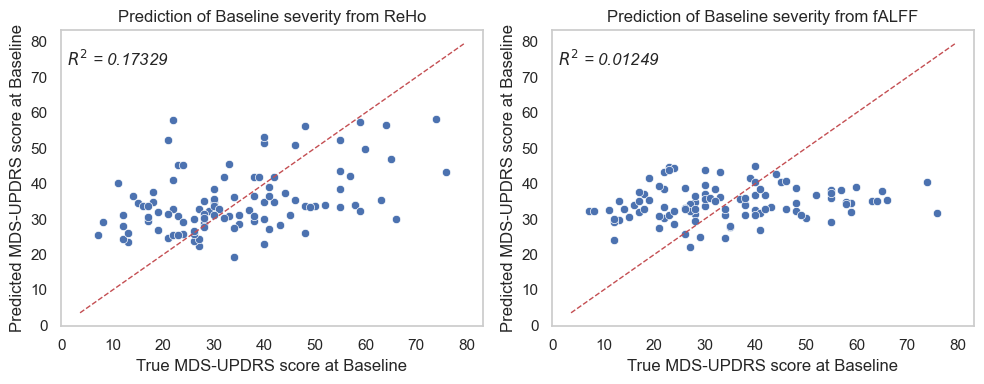

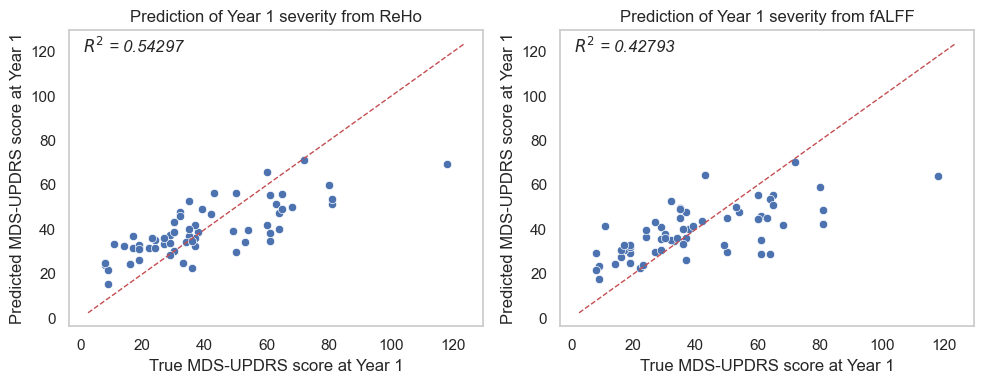

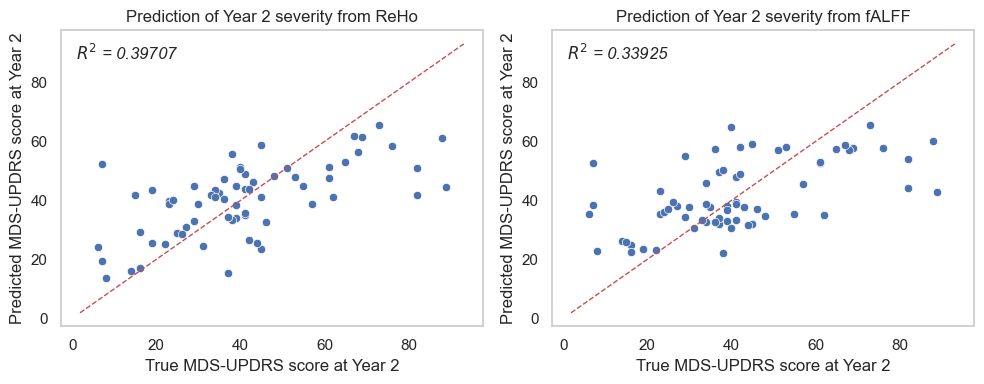

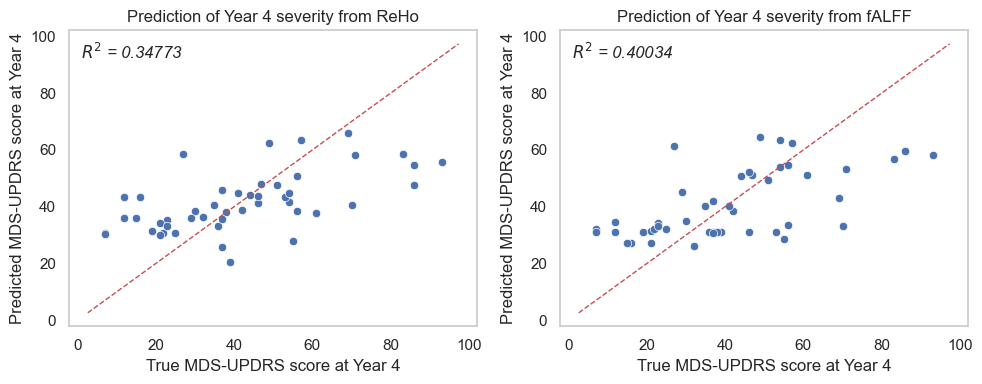

In [35]:
results.plot_pred_real(pipeline, global_df)

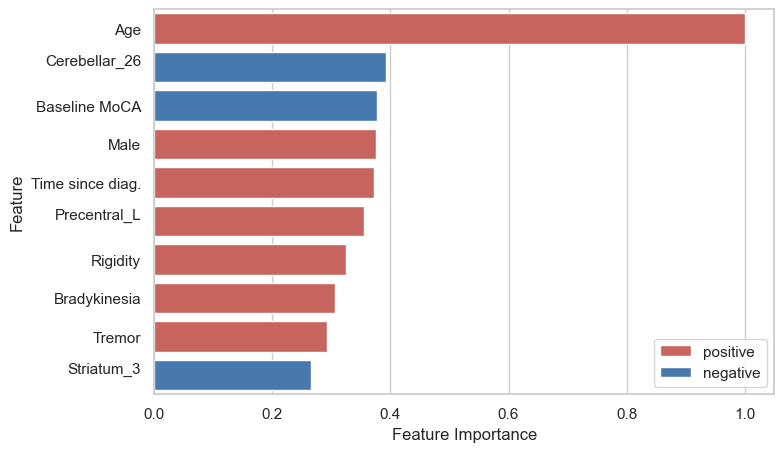

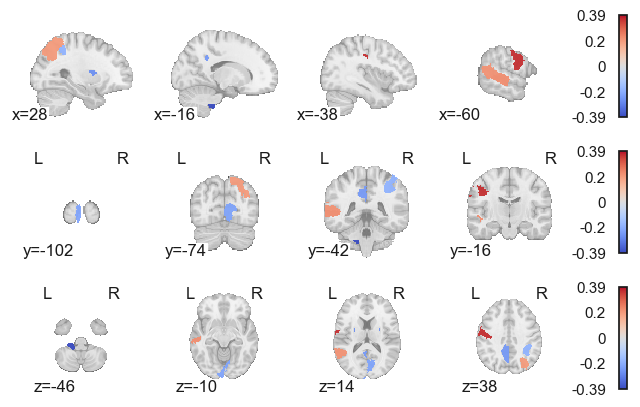

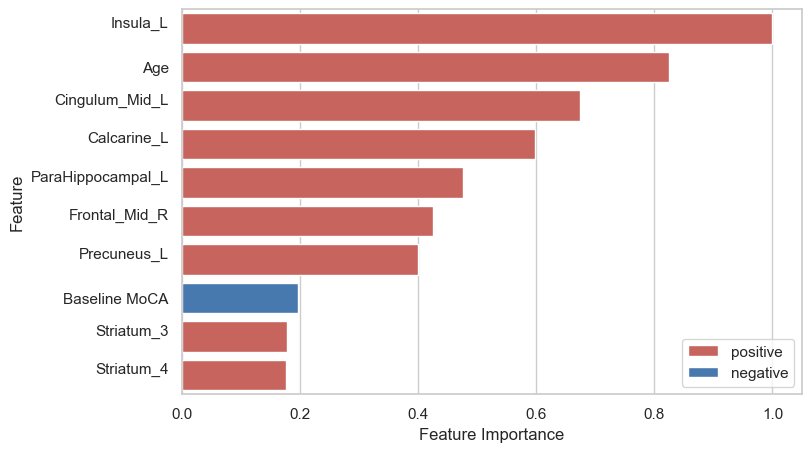

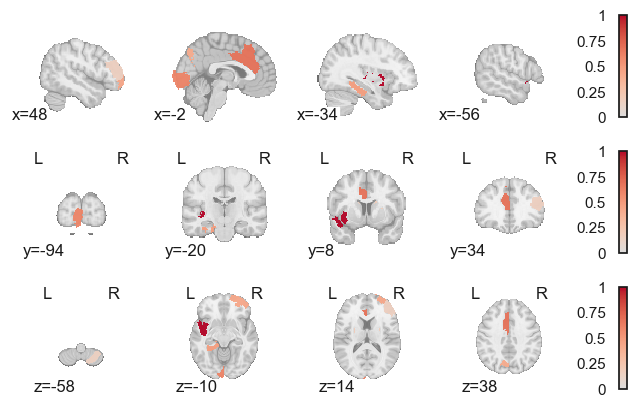

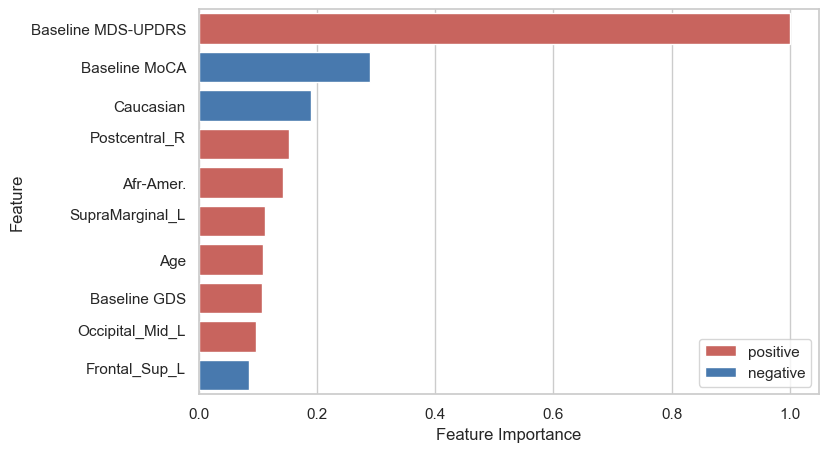

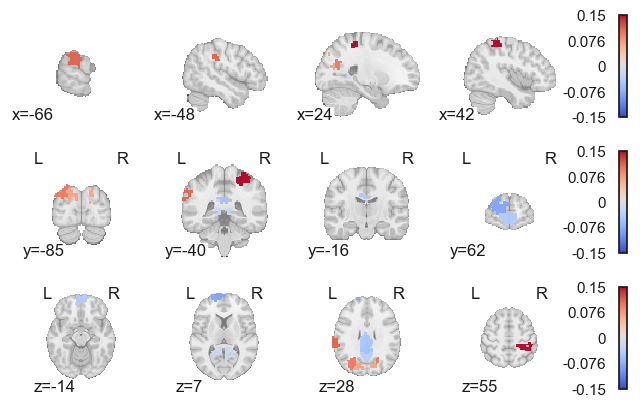

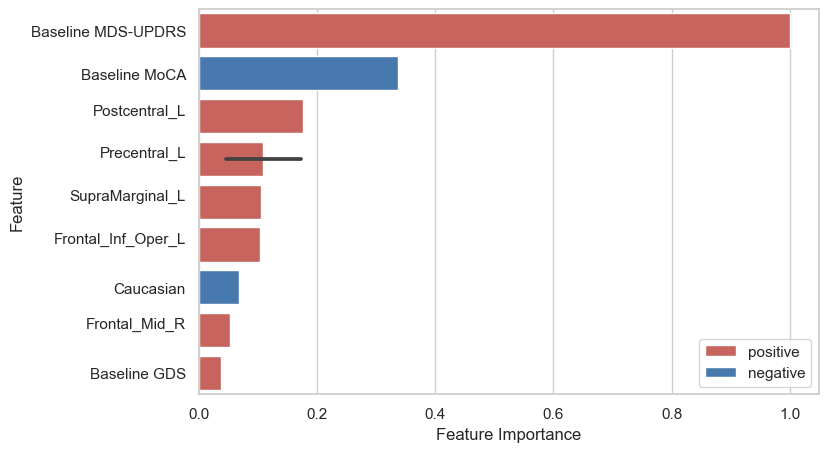

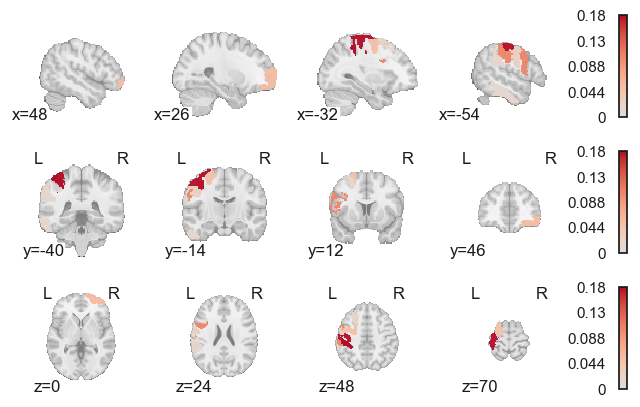

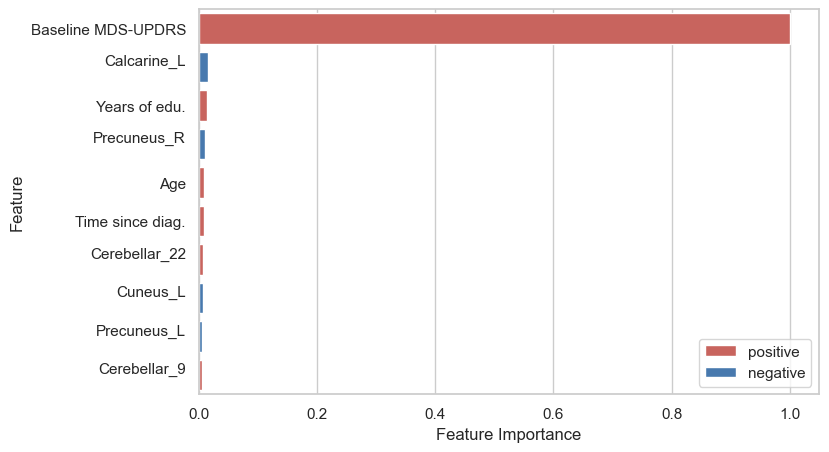

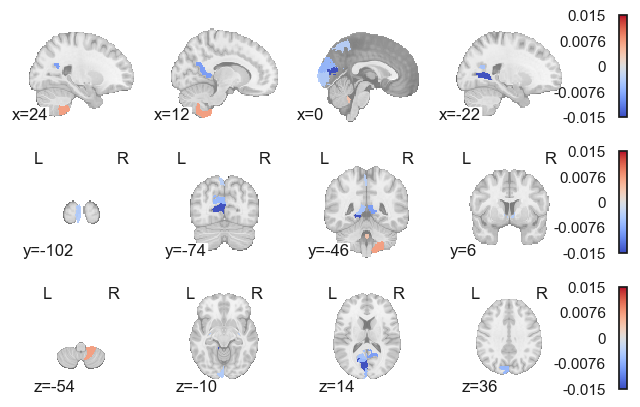

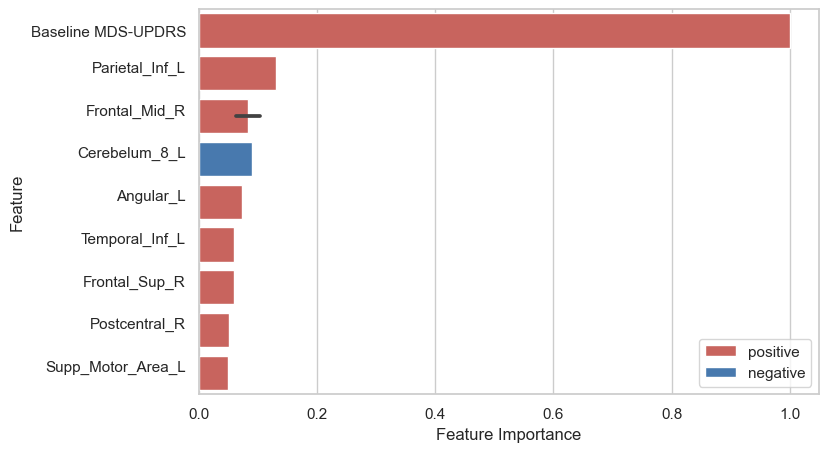

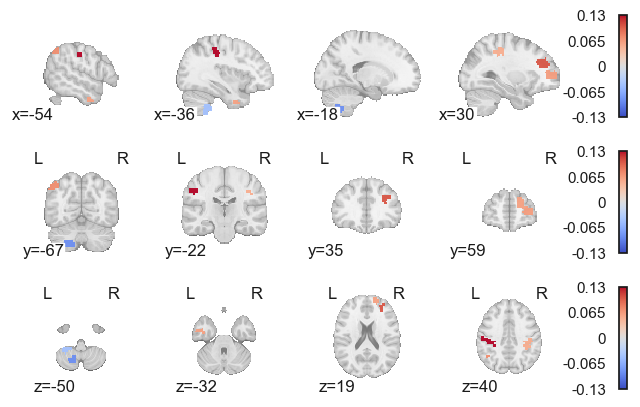

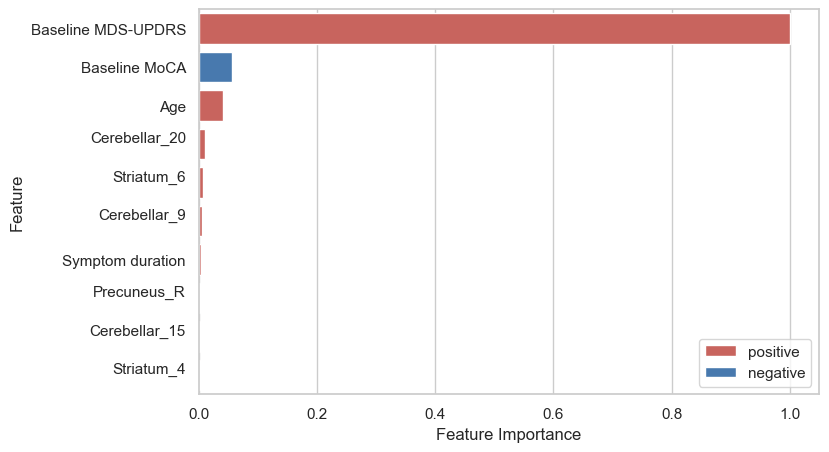

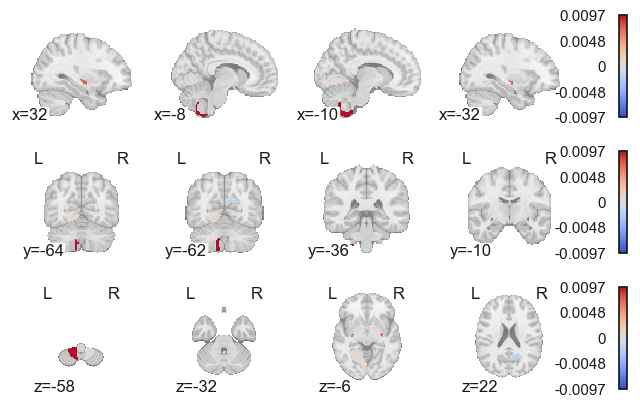

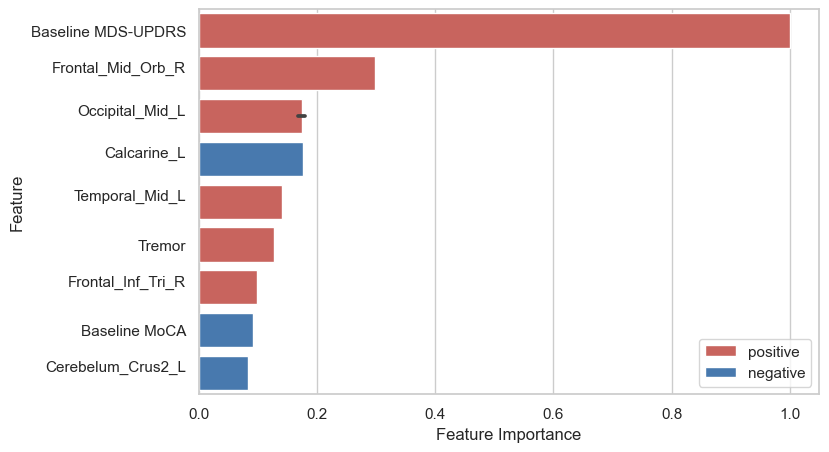

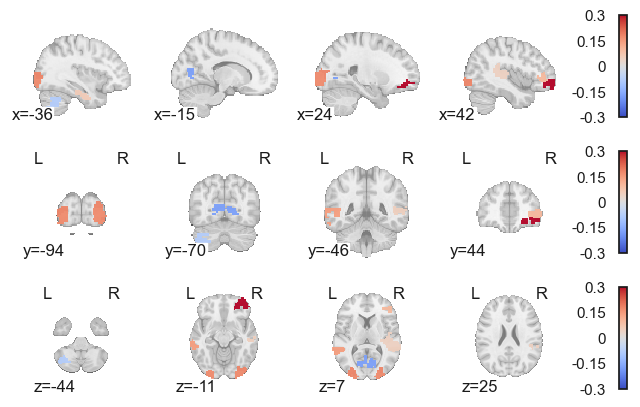

In [86]:
from nguyenetal.results import feature_importance
import importlib
importlib.reload(feature_importance)
feature_importance.plot_all_feature_importance(global_df, pipeline)